In [1]:
import warnings
warnings.filterwarnings('ignore')
import torch
dtype = torch.float
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from torch.distributions import normal
import matplotlib.pyplot as plt, numpy as np, pickle
from scipy.stats import norm
from tifffile import imread
import sys
sys.path.append('../')
#from pn2v import *
from lib.gaussianMixtureNoiseModel import GaussianMixtureNoiseModel
from lib import histNoiseModel
from lib.utils import plotProbabilityDistribution
import os
import urllib
import zipfile
from pathlib import Path

In [14]:
# Data paths
data_path_signal = Path(r"E:\dl_monalisa\Data\Vim_fixed_mltplSNR_30nm\inference\N2V\Vim_fixed_Avg1-3_no_clipping")
data_path_obs = Path(r"E:\dl_monalisa\Data\Vim_fixed_mltplSNR_30nm\dump\rec\timelapses_gathered")

# Parameters
noise_level = "all" # "all",list of int, or int
display = True # display images and histograms or not
hist_bins = 512
clip = -3 # False or clip value

print(f"Noise level: {noise_level}")

signal_avg = []
signal_n2v = []
observation = []
filters = ['tif','tiff']

files_signal = os.listdir(data_path_signal)
files_obs = os.listdir(data_path_obs)

for f in files_signal:
    if f.split('.')[-1] not in filters:
        print(f"removing {f} in signals because not in filters")
        files_signal.remove(f)

for f in files_obs:
    if f.split('.')[-1] not in filters:
        print(f"Removing {f} in observations because not in filters")
        files_obs.remove(f)

assert len(files_obs) == len(files_signal)
print(f"\nFound {len(files_signal)} files.\n")

for i in range (len(files_obs)):
    file_signal = files_signal [i]
    file_obs = files_obs [i]
    
    im_signal_avg = imread(data_path_signal / file_signal)[0]
    im_signal_n2v = imread(data_path_signal / file_signal)[1]
    
    # noise level selection
    if noise_level == "all":
        im_obs  = imread(data_path_obs / file_obs)[:5]
    elif isinstance(noise_level,int) or isinstance(noise_level,list):
        im_obs = imread(data_path_obs / file_obs)[noise_level]

    if not isinstance(clip,bool):
        im_obs[im_obs<clip] = 0
        im_signal_avg[im_signal_avg<clip] = 0
        im_signal_n2v[im_signal_n2v<clip] = 0

    observation.append(im_obs)
    signal_avg.append(im_signal_avg)
    signal_n2v.append(im_signal_n2v)

    print(f"Signal {file_signal}:\tObservation {file_obs}:\t Shape: {im_obs.shape}")

signal_avg = np.stack(signal_avg)
signal_n2v = np.stack(signal_n2v)
observation = np.stack(observation)

if len(observation.shape) == 4:
    nrepeat = observation.shape[1]
    observation = np.reshape(observation,(observation.shape[0]*observation.shape[1],observation.shape[2],observation.shape[3])) 
    signal_avg = np.repeat(signal_avg,nrepeat,axis=0)   
    signal_n2v = np.repeat(signal_n2v,nrepeat,axis=0)


signal_avg = (signal_avg - np.mean(signal_avg))/np.std(signal_avg)
signal_n2v = (signal_n2v - np.mean(signal_n2v))/np.std(signal_n2v)
observation = (observation - np.mean(observation))/np.std(observation)


print(f"\n\nConcatenated arrays:\tSignal avg: {signal_avg.shape}\tSignal n2v: {signal_n2v.shape}\tObservation: {observation.shape}")


Noise level: all

Found 25 files.

Signal img_and_denoised_00.tiff:	Observation rec_c01_rec_CAM.tiff:	 Shape: (5, 1416, 1392)
Signal img_and_denoised_01.tiff:	Observation rec_c02_rec_CAM.tiff:	 Shape: (5, 1416, 1392)
Signal img_and_denoised_02.tiff:	Observation rec_c03_rec_CAM.tiff:	 Shape: (5, 1416, 1392)
Signal img_and_denoised_03.tiff:	Observation rec_c04_rec_CAM.tiff:	 Shape: (5, 1416, 1392)
Signal img_and_denoised_04.tiff:	Observation rec_c05_rec_CAM.tiff:	 Shape: (5, 1416, 1392)
Signal img_and_denoised_05.tiff:	Observation rec_c07_rec_CAM.tiff:	 Shape: (5, 1416, 1392)
Signal img_and_denoised_06.tiff:	Observation rec_c08_rec_CAM.tiff:	 Shape: (5, 1416, 1392)
Signal img_and_denoised_07.tiff:	Observation rec_c09_rec_CAM.tiff:	 Shape: (5, 1416, 1392)
Signal img_and_denoised_08.tiff:	Observation rec_c10_rec_CAM.tiff:	 Shape: (5, 1416, 1392)
Signal img_and_denoised_09.tiff:	Observation rec_c11_rec_CAM.tiff:	 Shape: (5, 1416, 1392)
Signal img_and_denoised_10.tiff:	Observation rec_c12_re

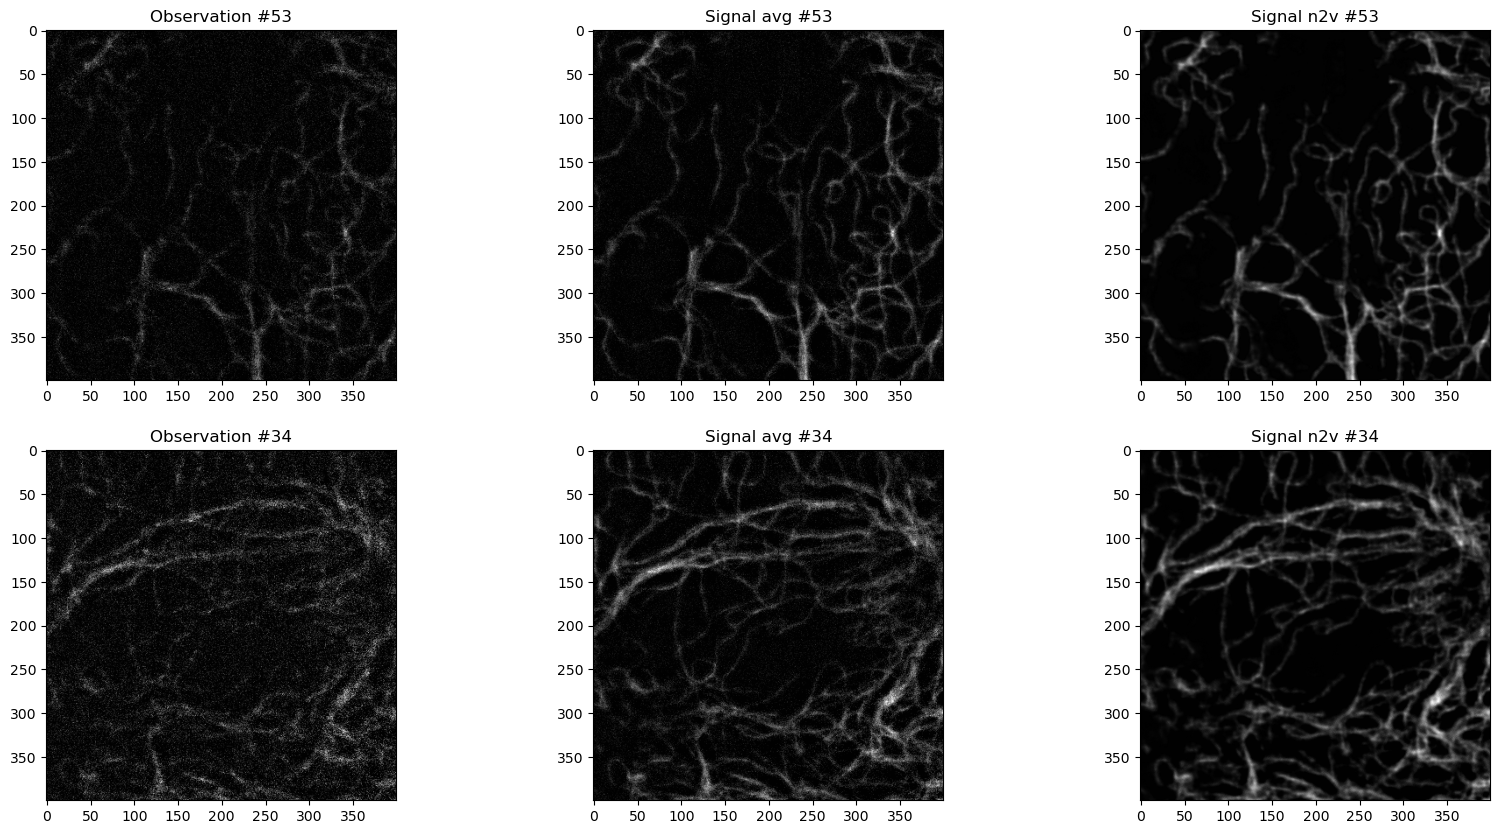

In [15]:
# Display examples of signals and observations if display is set to True

crop_size = 400
h,w = observation[0].shape

starty,startx = h//2-crop_size//2, w//2-crop_size//2
stopy,stopx = h//2+crop_size//2,w//2+crop_size//2

if display:
    idxs = np.random.randint(0,observation.shape[0],2)
    plt.figure(figsize=(20,10))
    for i in range(len(idxs)):
        sign2v = signal_n2v[idxs[i],starty:stopy,starty:stopy]
        sigavg = signal_avg[idxs[i],starty:stopy,starty:stopy]
        obs = observation[idxs[i],starty:stopy,starty:stopy]
        plt.subplot(2,3,3*i+1)
        plt.imshow(obs,cmap="gray")
        plt.title(f"Observation #{idxs[i]}")
        plt.subplot(2,3,3*i+2)
        plt.imshow(sigavg,cmap="gray")
        plt.title(f"Signal avg #{idxs[i]}")
        plt.subplot(2,3,3*i+3)
        plt.imshow(sign2v,cmap="gray")
        plt.title(f"Signal n2v #{idxs[i]}")

In [16]:
# create histograms
minVal, maxVal = np.min(signal_avg), np.max(signal_avg)
histogram_avg = histNoiseModel.createHistogram(hist_bins, minVal, maxVal, observation,signal_avg)

minVal, maxVal = np.min(signal_n2v), np.max(signal_n2v)
histogram_n2v = histNoiseModel.createHistogram(hist_bins, minVal, maxVal, observation,signal_n2v)


In [11]:
noiseModelsDir = r"E:\dl_monalisa\Data\Vim_fixed_mltplSNR_30nm\noise_models\final"
l=os.listdir(noiseModelsDir)
for f in l:
    print(f)

GMM_Noise0_SigAVG_Clip-3.npz
GMM_Noise0_SigN2V_Clip-3.npz
GMM_Noise1234_bootstrapped_Clip-3.npz
GMM_Noise1234_SigAVG_Clip-3.npz
GMM_Noise1234_SigAVG_Clip-3_2.npz
GMM_Noise1234_SigN2V_Clip-3.npz
GMM_Noise1_SigN2V_Clip-3.npz
GMM_Noise3_bootstrapped_Clip-3.npz
GMM_Noise3_SigN2V_Clip-3.npz
GMM_Noise4_SigN2V_Clip-3.npz
info.txt.txt


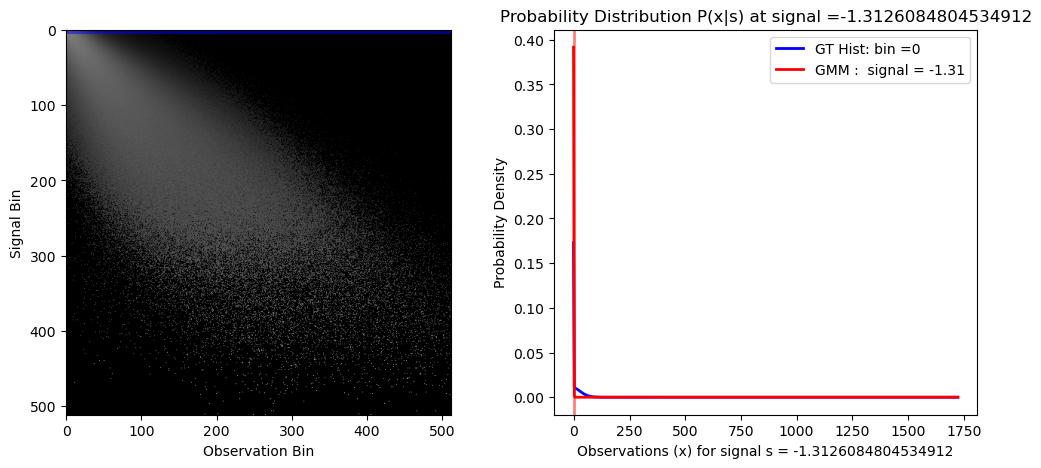

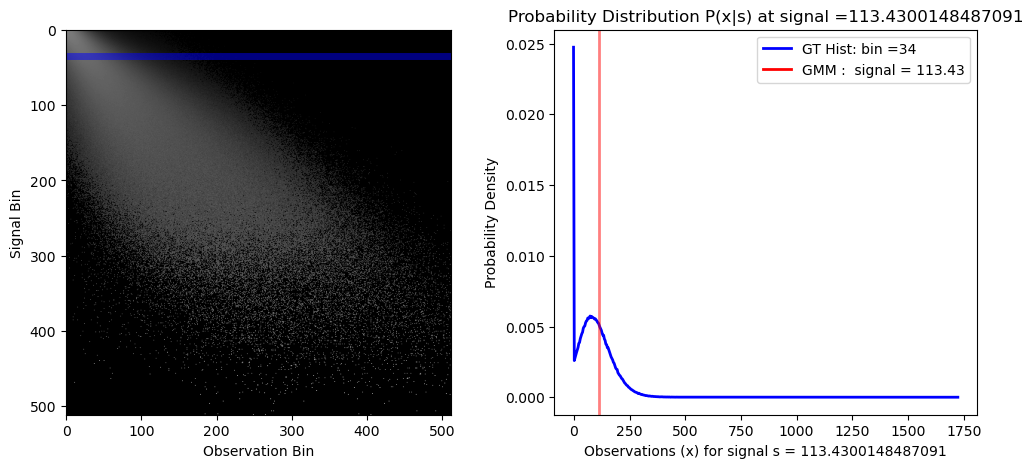

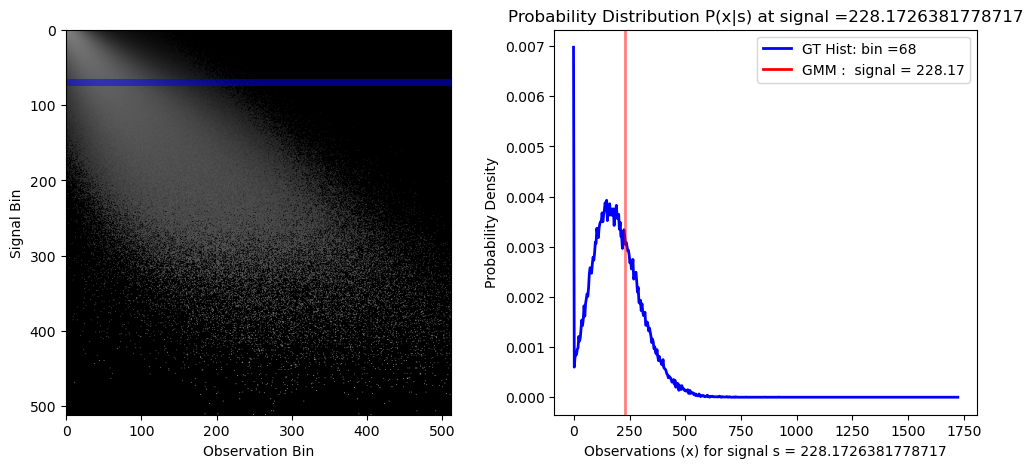

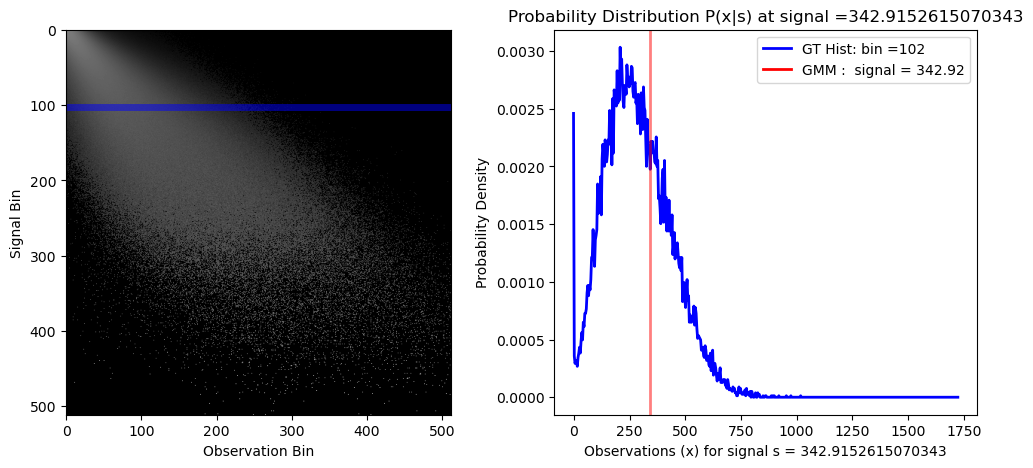

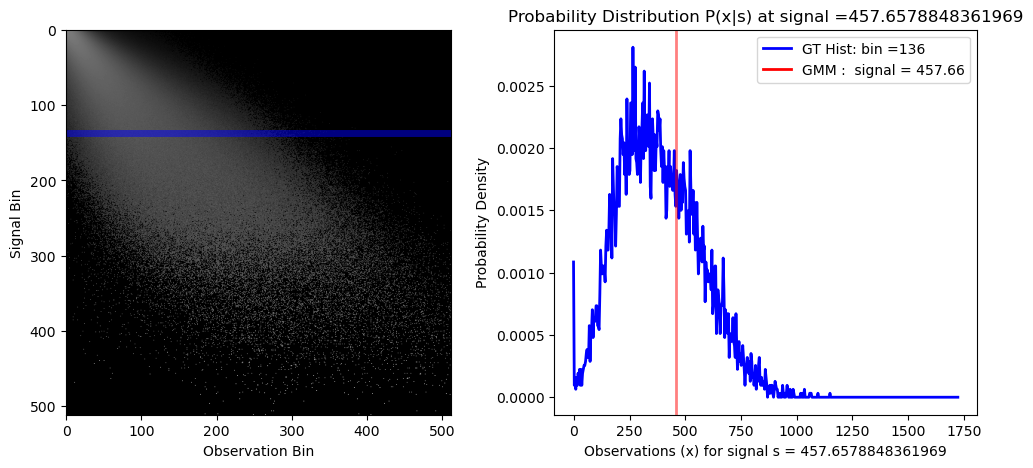

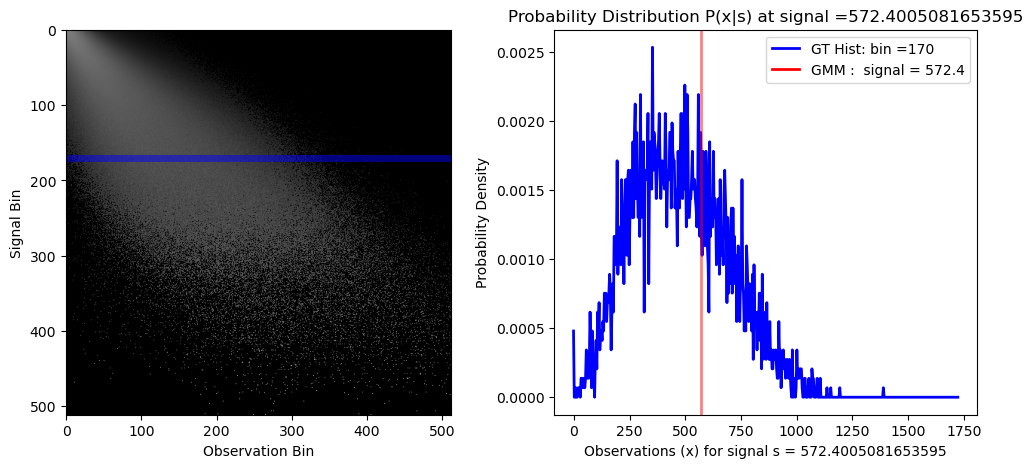

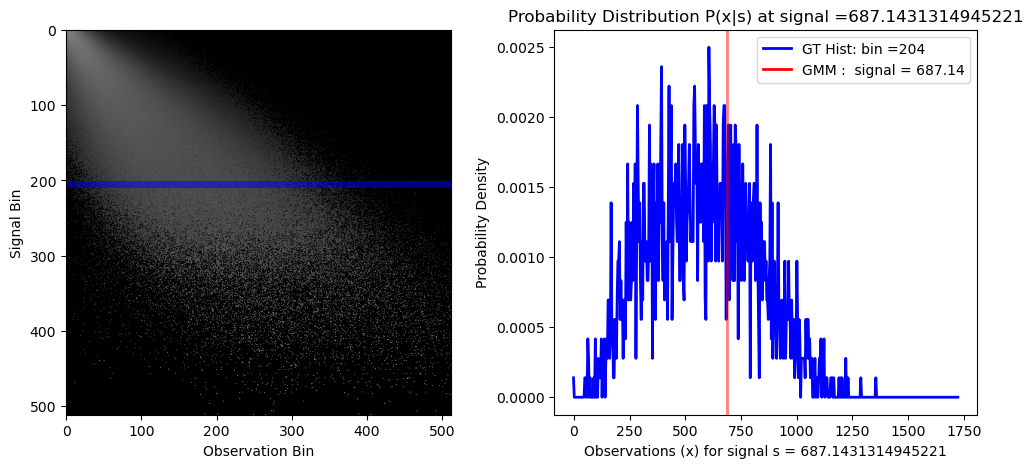

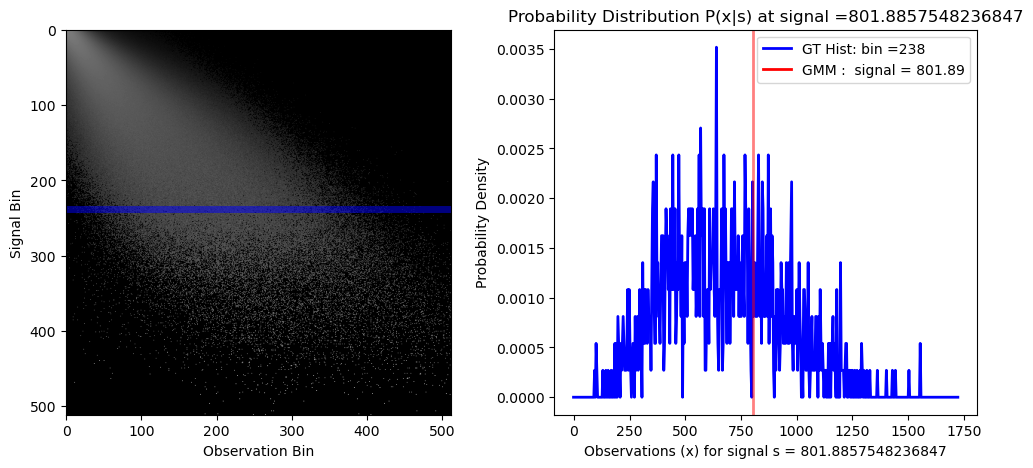

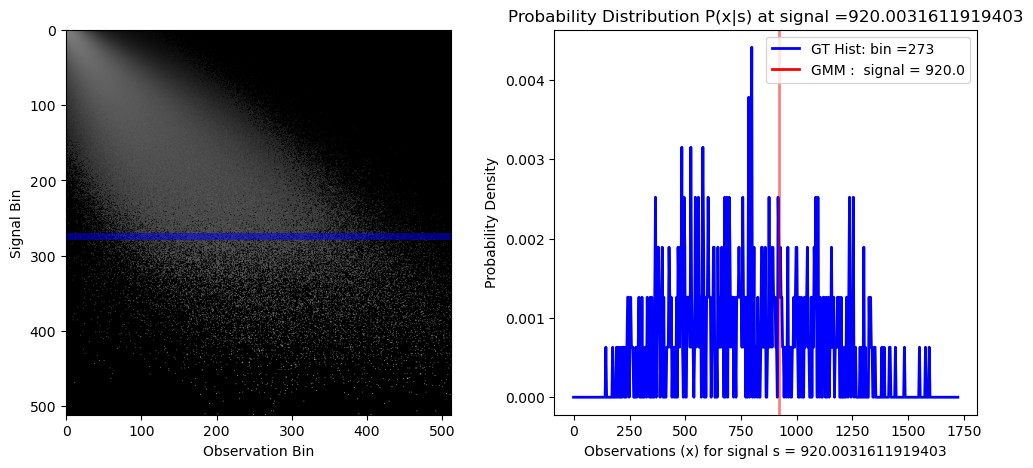

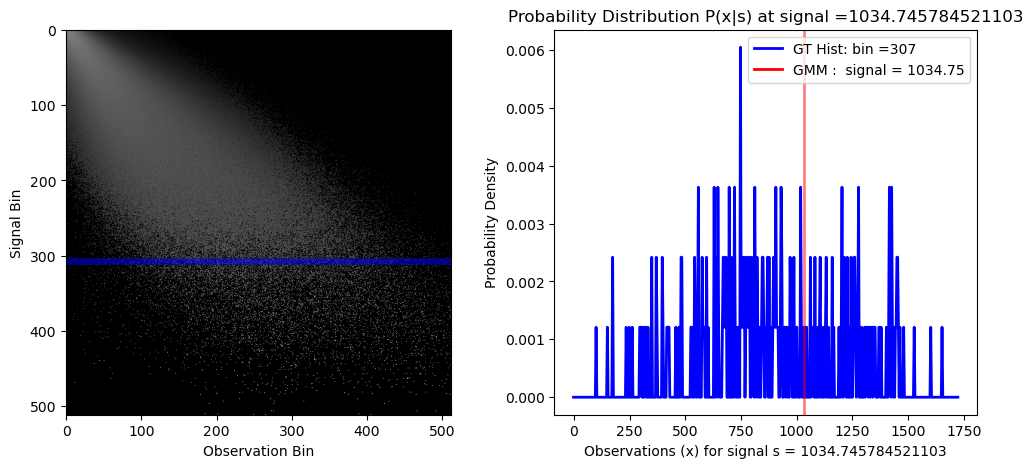

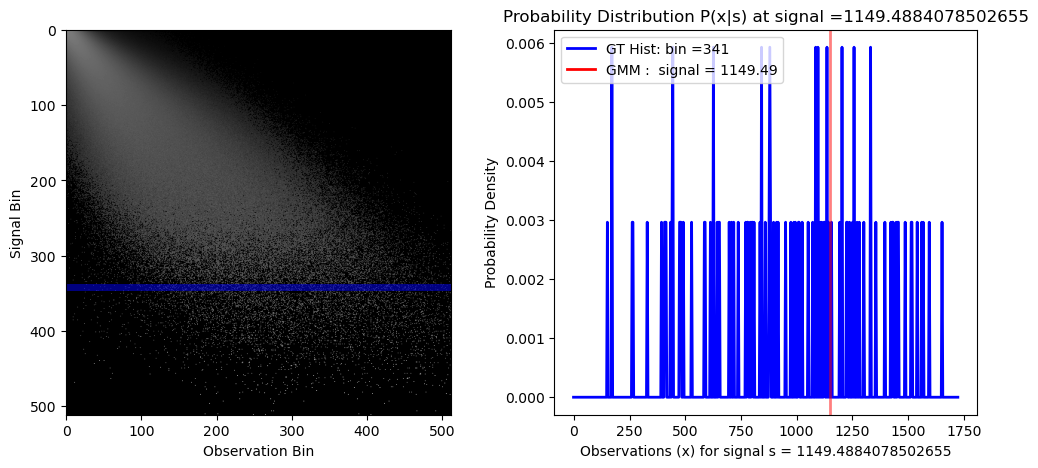

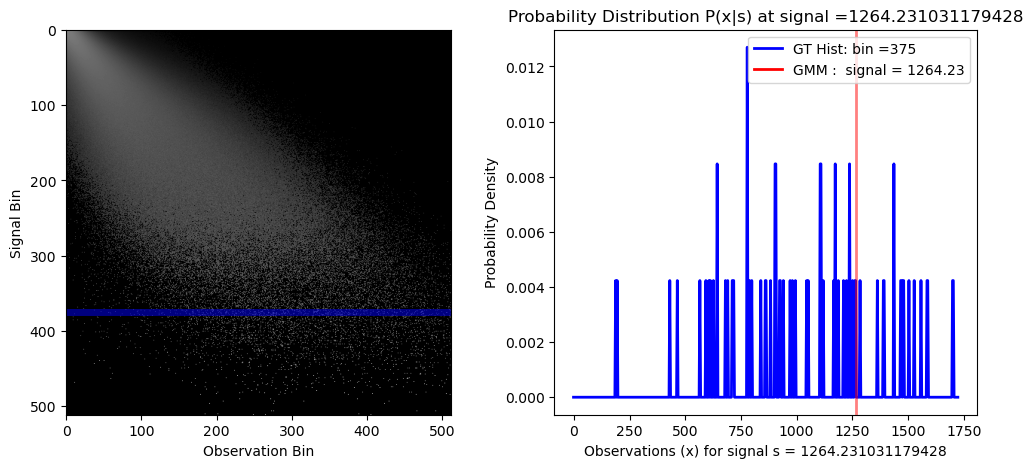

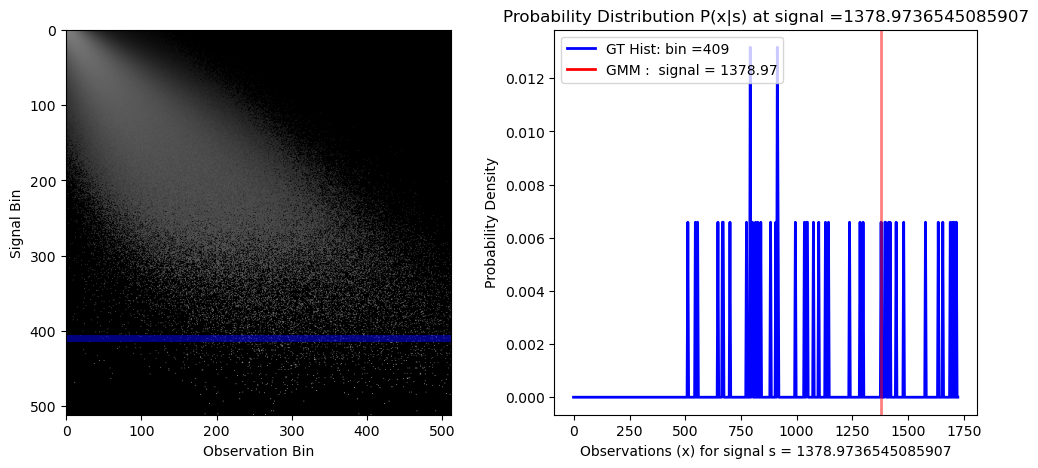

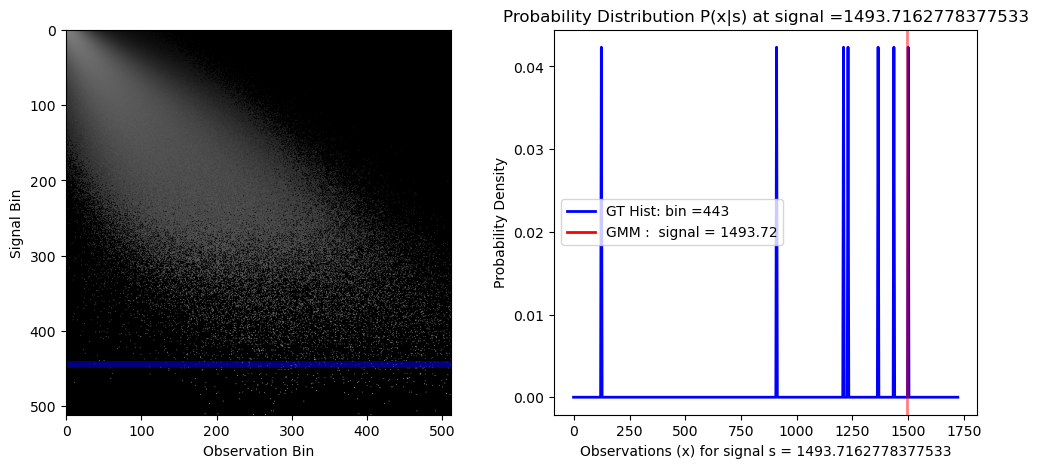

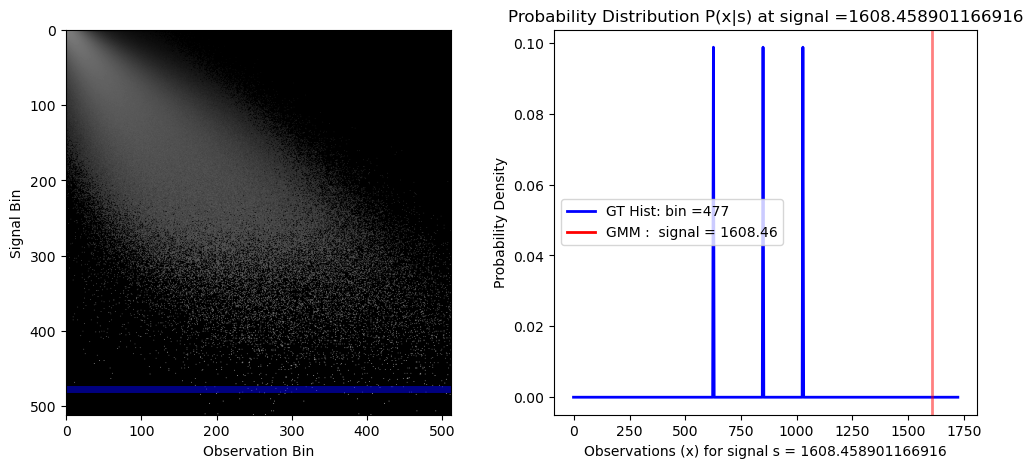

In [17]:
# Noise model folder

GMMtoDisplay = "avg"
histToDisplay = histogram_n2v[0]

noiseModelName_avg = "GMM_Noise1234_SigN2V_Clip-3.npz"
# noiseModelName_n2v = "GMM_Noise0_SigN2V_Clip-3_nGauss4_nCoeff5.npz"

noise_model_params_avg= np.load(os.path.join(noiseModelsDir,noiseModelName_avg))
# noise_model_params_n2v= np.load(os.path.join(noiseModelsDir,noiseModelName_n2v))

noiseModel_avg = GaussianMixtureNoiseModel(params = noise_model_params_avg, device = device) 
# noiseModel_n2v = GaussianMixtureNoiseModel(params = noise_model_params_n2v, device = device) 

n_points = 15
signalBinIndex_list = (np.linspace(0,n_points-1,n_points)*hist_bins//n_points).astype(int)

if GMMtoDisplay == "avg":
    for binidx in signalBinIndex_list:
        plotProbabilityDistribution(signalBinIndex=binidx, histogram=histToDisplay, gaussianMixtureNoiseModel=noiseModel_avg, min_signal=minVal, max_signal=maxVal, n_bin=hist_bins, device=device)

if GMMtoDisplay == "n2v":
    for binidx in signalBinIndex_list:
        plotProbabilityDistribution(signalBinIndex=binidx, histogram=histToDisplay, gaussianMixtureNoiseModel=noiseModel_n2v, min_signal=minVal, max_signal=maxVal, n_bin=hist_bins, device=device)